<a href="https://colab.research.google.com/github/Yaroshenkom/PhD/blob/main/data_driven_point_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 8.2 MB/s 
     |████████████████████████████████| 381 kB 34.3 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=6513cf8eb3d14cd7ed325509a558e585ff3154c67fbc564ac6e216da4e58eea7
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [ ]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ipdb

from munkres import Munkres

# import tensorflow as tf
# from tensorflow.keras.utils import plot_model

import os
import math
import cmath
import numpy as np
import numpy.matlib
import scipy as sc
import PIL

import skimage

from skimage import morphology
from PIL import Image
from tensorflow import keras
from keras import layers

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt


Also we should set the random seed for all necessary packages (TensorFlow, Numpy, etc.)

In [ ]:
seed = 4962
# For TemsorFlow
# rng = tf.random.experimental.Generator.from_seed(seed)
# For Numpy
rng = np.random.default_rng(seed)

In [ ]:
for i in range(3):
    vals = rng.uniform(size=10)
    print(vals)

[0.35508888 0.02802069 0.06729991 0.48469051 0.79655034 0.7639453
 0.96908567 0.56545649 0.87339362 0.0930666 ]
[0.44398809 0.21174987 0.89239979 0.19804297 0.32953857 0.22522735
 0.94312645 0.01805941 0.46891955 0.5994245 ]
[0.44401152 0.1093277  0.5127621  0.40039761 0.03553833 0.79917598
 0.3507365  0.34880546 0.87561322 0.69701818]


Here we turn on the GPU.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


## Input pattern function
Create input laser beam pattern.

In [ ]:
def gen_in_circles(init_points_num, num_of_circ, rad_init):
    # Calculate the amount of points
    num_of_pts_total = 0
    for i in range(1, num_of_circ+1):
        num_of_pts_total = num_of_pts_total + init_points_num * i;
    
    out_pts = np.zeros((num_of_pts_total, 2))

    # The output pattern consists coaxial circles
    curr_pt = -1
    for i in range(1, num_of_circ+1):
        # Radius and amount of points in current circle
        rad = rad_init * i
        num_of_pts = init_points_num * i
        for j in range(0,num_of_pts):
            curr_pt = curr_pt + 1
            out_pts[curr_pt] = [rad * math.cos(j/num_of_pts * 2 * math.pi), rad * math.sin(j/num_of_pts * 2 * math.pi)]
            
    return (out_pts, num_of_pts_total)

Show input pattern

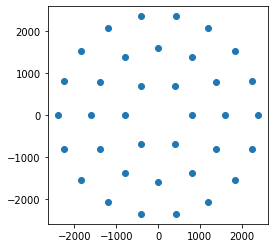

In [ ]:
in_pts, num_of_pts_total = gen_in_circles(6, 3, 800)

plt.scatter(in_pts[:, 0], in_pts[:, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Eye model functions
In our case eye model will be very simple:
+ all the input beams are parallel to the main optical axis of the eye
+ all the input beams are converge on the retina in the point with the coordinates (0,0)
+ aberrations described by Zernike coefficients cause beams to incline from the (0,0) 

## osa2nm_gen(j_idx)
This funcion converts OSA/ANSI index to `n` and `m` needed for calculation of Zernike polynomials, for more: 
https://en.wikipedia.org/wiki/Zernike_polynomials


In [ ]:
def osa2nm_gen(j_idx):
    i = 0
    curr_n = 0
    n = []
    m = []
    while 1:
        for idx in range(-curr_n, curr_n+1, 2):
            n.append(curr_n)
            m.append(idx)
            i = i + 1
            if (i >= j_idx):
                n = np.array(n)
                m = np.array(m)
                return (n, m)   
        
        curr_n = curr_n + 1
    

In [ ]:
print(osa2nm_gen(28))

(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6]), array([ 0, -1,  1, -2,  0,  2, -3, -1,  1,  3, -4, -2,  0,  2,  4, -5, -3,
       -1,  1,  3,  5, -6, -4, -2,  0,  2,  4,  6]))


## calc_Rnm(ro, n, m)
The function below calculates Rnm(ro) (formula 7 of the 
http://pbf.kpi.ua/en/docs/publications/Molebny_Retina_ray-tracing_technique.pdf - it has typo, here is the correct variant)

In [ ]:
from scipy.special import factorial as factorial

def calc_Rnm(ro, n, m):
    Rnm = 0.0
    for k in range( int(( n-abs(m) )/2) + 1):
        Rnm = Rnm + ((-1)**k) * factorial(n-k) * (ro**(n-2*k)) / \
        (factorial(k) * factorial((n+abs(m))/2 - k) * factorial((n-abs(m))/2 - k)) 
    return Rnm

## calc_dRnm_dro(ro, n, m)
The function below calculates partial derivative dRnm(ro)/dro 
(formula 14 of the 
http://pbf.kpi.ua/en/docs/publications/Molebny_Retina_ray-tracing_technique.pdf )

In [ ]:
def calc_dRnm_dro(ro, n, m):
    dRnm_dro = 0.0
    for k in range( int(( n-abs(m) )/2) + 1):
        dRnm_dro = dRnm_dro + ((-1)**factorial(n-k)) * (n-2*k) * (ro**(n-2*k-1)) / \
            (factorial(k) * factorial( ( n-abs(m) )/2 - k ) * factorial(( n+abs(m) )/2-k))
    return dRnm_dro

## calc_A(in_pts, pupil_radius, C_idx)
This function calculates the `A` matrix which gives inclination vector `F = [Ay; Ax]` after multiplication by Zernike coefficients `C`:
`F = AC`

In [ ]:
def calc_A(in_pts, pupil_radius, C_idx):
    # ipdb.set_trace()
    # Get ro and phi for each input point
    pts_num = np.size(in_pts, 0)
    ro_in = np.zeros((pts_num, 1))
    phi_in = np.zeros((pts_num, 1))
    for i in range(pts_num):
        ro_in[i], phi_in[i] = cmath.polar(in_pts[i,0] / pupil_radius + (in_pts[i,1] / pupil_radius) * 1j)
    # phi_in = np.transpose((phi_in)[np.newaxis])
    # ro_in = np.transpose((ro_in)[np.newaxis])
    
    #  ro_in = ro_in ./ pupil_radius;

    # Get n and m for current C
    n, m = osa2nm_gen(C_idx)
    n = n[1:np.size(n,0)]
    n = np.transpose((n)[np.newaxis])
    m = m[1:np.size(m,0)]
    m = np.transpose((m)[np.newaxis])

    # Eye's diameter in meters to be compatible with traditional value of
    # the eye's refraction index
    R_eye = 0.023700
    # Eye's refraction index
    n_refr = 1.336
    
    # Calculare A - the matrix of numbers before Zernike coefficients
    # - elements for dy's Cnm
    Ay = np.zeros((np.size(in_pts,0), np.size(n,0)))
    for i in range(np.size(in_pts,0)):
        for j in range(np.size(n,0)):
            if (m[j] >= 0):
                Ay[i,j] = (R_eye/n_refr) * math.cos(phi_in[i]) * math.cos(m[j]*phi_in[i])* \
                    calc_dRnm_dro(ro_in[i], n[j], m[j]) + \
                    (R_eye/n_refr) * (math.sin(phi_in[i])/ro_in[i]) * m[j]* \
                    calc_Rnm(ro_in[i], n[j], m[j])*math.sin(m[j]*phi_in[i])
            else:
                Ay[i,j] = (R_eye/n_refr) * math.cos(phi_in[i]) * math.sin(-m[j]*phi_in[i])* \
                    calc_dRnm_dro(ro_in[i], n[j], m[j]) + \
                    (R_eye/n_refr) * (-math.sin(phi_in[i])/ro_in[i]) * (-m[j])* \
                    calc_Rnm(ro_in[i], n[j], m[j])*math.cos(-m[j]*phi_in[i])
            
    # - elements for dx's Cnm
    Ax = np.zeros((np.size(in_pts,0), np.size(n,0)))
    for i in range(np.size(in_pts,0)):
        for j in range(np.size(n,0)):
            if (m[j] >= 0):
                Ax[i,j] = (R_eye/n_refr) * math.sin(phi_in[i]) * math.cos(m[j]*phi_in[i])* \
                    calc_dRnm_dro(ro_in[i], n[j], m[j]) + \
                    (R_eye/n_refr) * (-math.cos(phi_in[i])/ro_in[i]) * m[j]* \
                    calc_Rnm(ro_in[i], n[j], m[j])*math.sin(m[j]*phi_in[i])
            else:
                Ax[i,j] = (R_eye/n_refr) * math.sin(phi_in[i]) * math.sin(-m[j]*phi_in[i])* \
                    calc_dRnm_dro(ro_in[i], n[j], m[j]) + \
                    (R_eye/n_refr) * (math.cos(phi_in[i])/ro_in[i]) * (-m[j])* \
                    calc_Rnm(ro_in[i], n[j], m[j])*math.cos(-m[j]*phi_in[i])  

    # Compose the full A matrix
    A = np.concatenate((Ay, Ax), 0)

    return A

## zernshift(ro, phi, C)
This function calculates image shift `dx` and `dy` due to Zernike coeffecients `C` of eye's optical system. `ro` should be 0<=ro<=1. 

More info in section 4 of
http://pbf.kpi.ua/en/docs/publications/Molebny_Retina_ray-tracing_technique.pdf 

In [ ]:
def zernshift(ro, phi, C):
    # Get n and m for current C
    n, m = osa2nm_gen(np.size(C, 0));
    n = np.transpose(n)
    m = np.transpose(m)

    # Calculate shifts:
    # 1. Calculate partial derivative dRnm(ro)/dro (formula 14 of the link)
    dRnm_dro = np.zeros(np.size(n, 0))
    for i in range(0, np.size(n,0)):
        # ipdb.set_trace()
        for k in range(0, int(( n[i]-abs(m[i]) )/2) + 1):
            dRnm_dro[i] = dRnm_dro[i] + ((-1)**math.factorial(n[i]-k)) * (n[i]-2*k) * (ro**(n[i]-2*k-1)) / \
                (math.factorial(k) * math.factorial( ( n[i]-abs(m[i]) )/2 - k ) * math.factorial(( n[i]+abs(m[i]) )/2-k))

    # 2. Calculate partial derivative dW(ro,phi)/dro (formula 13 of the link)
    # ipdb.set_trace()
    dW_dro = 0.0
    for i in range(0, np.size(n,0)):
        tmp = 0.0
        if (m[i] < 0):
            # It's odd polynomial's derivative
            tmp = math.sin(abs(m[i]) * phi)
        else:
            # It's even polynomial's derivative
            tmp = math.cos(m[i] * phi)

        # Include norming coefficient Nnm
        #  delta = 0
        #  if (m(i) == 0):
            #  delta = 1
        #  
        #  Nnm = sqrt(2 * (n(i)+1) / (1 + delta));
        dW_dro = dW_dro + C[i] * dRnm_dro[i] * tmp
    
    # 3. Calculate Rnm(ro) (formula 7 of the link - it has typo, here is the correct variant)
    Rnm = np.zeros(np.size(n, 0))
    for i in range(0, np.size(n,0)):
        for k in range(0, int((n[i]-abs(m[i]))/2) + 1):
            Rnm[i] = Rnm[i] + ((-1)**k) * math.factorial(n[i]-k) * (ro**(n[i]-2*k)) / \
                (math.factorial(k) * math.factorial((n[i]+abs(m[i]))/2 - k) * math.factorial((n[i]-abs(m[i]))/2 - k))

    # 4. Calculate partial derivative dW(ro,phi)/dphi (formula 15 of the link)
    dW_dphi = 0.0
    for i in range(0, np.size(n,0)):
        tmp = 0.0
        if (m[i] < 0):
            # It's odd polynomial
            tmp = math.cos(abs(m[i]) * phi);
        else:
            # It's even polynomial
            tmp = -math.sin(m[i] * phi);
        
        # Include norming coefficient Nnm
        #  delta = 0;
        #  if m[i] == 0:
            #  delta = 1
        #  end
        #  Nnm = sqrt(2 * (n(i)+1) / (1 + delta))
        dW_dphi = dW_dphi + abs(m[i]) * C[i] * Rnm[i] * tmp
    
    # 5. Calculate shifts by themselves (formulas 11-12)
    # Focal distance (radius of ideal spherical wavefront)in meters to be compatible with traditional value of
    # the eye's refraction index
    R_eye = 0.017
    # Eye's refraction index
    n_refr = 1.336
    # Shifts (we swap x and y in formulas, because in the original Molebny's article they're swapped)
    dx = (R_eye/n_refr) * (math.cos(phi) * dW_dro - math.sin(phi) * dW_dphi / ro)
    dy = (R_eye/n_refr) * (math.sin(phi) * dW_dro + math.cos(phi) * dW_dphi / ro)

    return (dx, dy)

## zern_eye_model(x_in, y_in, pupil_radius, C)
This function models human eye's optical system as
a converging lens with aberration wavefront function defined by 
Zernike coefficients `C`. Pupil radius also has to be in um.
If you want unaberrated output - just make `C = 0`.

In [ ]:
def zern_eye_model(x_in, y_in, pupil_radius, C):
    # Eyeball's diameter and focal distance in um
    Diam_eye = 23700
    F_dist = 17000

    # Turn Cartesian coordinates into polar ones
    ro_in, phi_in = cmath.polar(x_in + y_in * 1j)

    # # Calculate unaberrated coordinates of input point (very simplified)
    # ro_out = ro_in * (Diam_eye-F_dist) / F_dist
    # phi_out = phi_in - cmath.pi
    
    # # Turn polar coordinates into Cartesian
    # z = cmath.rect(ro_out, phi_out)
    # x_out = z.real
    # y_out = z.imag

    # Add aberrations for Gaussian plane (in our case - focal plane)
    dx_norm, dy_norm = zernshift(ro_in/pupil_radius, phi_in, C)
    dx =  dx_norm*pupil_radius
    dy =  dy_norm*pupil_radius

    # Calculate shift caused by the aberration for the retina
    # - consider shifted point in Gaussian plane as a pseudo-focal point and calculate ro and phi
    ro_shift, phi_shift = cmath.polar((x_in - dx) + (y_in - dy) * 1j)
    ro_shift_out = ro_shift * (Diam_eye-F_dist) / F_dist
    phi_shift_out = phi_shift - cmath.pi
    # - turn polar coordinates into Cartesian
    z = cmath.rect(ro_shift_out, phi_shift_out)
    x_out = z.real
    y_out = z.imag
    # - translate current coorfinates to the system with center in focal point again
    x_out = x_out + dx
    y_out = y_out + dy

    # x_out = x_out + dx * pupil_radius
    # y_out = y_out + dy * pupil_radius

    return (x_out, y_out)

## zern_C_calc(A, out_pts, pupil_radius)
The function below calculates Zernike coefficients using Least Squares method.

In [ ]:
def zern_C_calc(A, out_pts, pupil_radius):
    # Compose the F matrix (we divide by pupil raduis in order to norm
    # values)
    F = np.concatenate((out_pts[:,1] / pupil_radius, out_pts[:,0] / pupil_radius), 0)

    # Calculate C using the method of least squares
    c_out = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(A), A)), np.transpose(A)), F)

    # We consider the coefficient with n=m=0 equal to 0s
    c_out = np.concatenate((np.array([0.0]), c_out), 0)
    return c_out

# Data preparation
We create a dataset consisting of laser spots on retina caused by parallel input laser beams directed in the eye and inclined by aberrations.

In [ ]:
# Amount of dataset elements
samples_num = 4000
train_valid_separation_coeff = 0.8
train_idxs = np.array(range(0, int(samples_num*train_valid_separation_coeff)))
valid_idxs = np.array(range(int(samples_num*train_valid_separation_coeff), samples_num))

# # Mins and maxes of Zernike coefficients (in um)
# C_min_max = np.array([
#     [0.000, 0.000],     # n=0, m=0
#     [0.000, 0.000],      # n=1, m=-1
#     [0.000, 0.000],      # n=1, m=1
#     [-1.50, 1.50],      # n=2, m=-2
#     [-1.00, 8.00],      # n=2, m=0
#     [-2.00, 1.00],      # n=2, m=2
#     [-0.50, 0.50],      # n=3, m=-3
#     [-0.50, 0.50],      # n=3, m=-1
#     [-0.50, 0.50],      # n=3, m=1
#     [-0.50, 0.50],      # n=3, m=3
#     [-0.50, 0.50],      # n=4, m=-4
#     [-0.50, 0.50],      # n=4, m=-2
#     [-0.50, 0.50],      # n=4, m=0
#     [-0.50, 0.50],      # n=4, m=2
#     [-0.50, 0.50],      # n=4, m=4
#     [-0.50, 0.50],      # n=5, m=-5
#     [-0.50, 0.50],      # n=5, m=-3
#     [-0.50, 0.50],      # n=5, m=-1
#     [-0.50, 0.50],      # n=5, m=1
#     [-0.50, 0.50],      # n=5, m=3
#     [-0.50, 0.50],      # n=5, m=5
#     [-0.50, 0.50],      # n=6, m=-6
#     [-0.50, 0.50],      # n=6, m=-4
#     [-0.50, 0.50],      # n=6, m=-2
#     [-0.50, 0.50],      # n=6, m=0
#     [-0.50, 0.50],      # n=6, m=2
#     [-0.50, 0.50],      # n=6, m=4
#     [-0.50, 0.50]       # n=6, m=6
# ])

# # Generate random normalized Zernike coefficients
# rng = np.random.default_rng(seed)
# C_norm_rnd = rng.uniform(0.0, 1, (samples_num, np.size(C_min_max, 0)))
# C_norm_rnd[:,0] = 0
# C_rnd = np.matlib.repmat(C_min_max[:,0], samples_num, 1) + \
#             np.multiply(np.matlib.repmat(C_min_max[:,1] - C_min_max[:,0], samples_num, 1), \
#                       C_norm_rnd)

# Mean values and standard deviations of Zernike coefficients (which define mean values and standard deviations of Zernike modes)
C_avg_std = np.array([
    [0.00, 0.00],     # n=0, m=0
    [0.00, 0.00],     # n=1, m=-1
    [0.00, 0.00],     # n=1, m=1
    [0.000, 0.00],    # n=2, m=-2
    [ 0, 0.4],    # n=2, m=0
    [-0.4, 0.5],    # n=2, m=2
    [-0.05, 0.1],      # n=3, m=-3
    [0.0, 0.2],      # n=3, m=-1
    [0.0, 0.1],      # n=3, m=1
    [0.0, 0.1],      # n=3, m=3
    [0.0, 0.1],      # n=4, m=-4
    [0.0, 0.1],      # n=4, m=-2
    [0.1, 0.1],      # n=4, m=0
    [0.0, 0.1],      # n=4, m=2
    [0.0, 0.1],      # n=4, m=4
    [0.0, 0.05],      # n=5, m=-5
    [0.0, 0.05],      # n=5, m=-3
    [0.0, 0.05],      # n=5, m=-1
    [0.0, 0.05],      # n=5, m=1
    [0.0, 0.05],      # n=5, m=3
    [0.0, 0.05],      # n=5, m=5
    [0.0, 0.05],      # n=6, m=-6
    [0.0, 0.05],      # n=6, m=-4
    [0.0, 0.05],      # n=6, m=-2
    [0.0, 0.05],      # n=6, m=0
    [0.0, 0.05],      # n=6, m=2
    [0.0, 0.05],      # n=6, m=4
    [0.0, 0.05]       # n=6, m=6
])

# # Mean values and standard deviations of Zernike coefficients (which define mean values and standard deviations of Zernike modes)
# C_avg_std = np.array([
#     [0.00, 0.00],     # n=0, m=0
#     [0.00, 0.00],     # n=1, m=-1
#     [0.00, 0.00],     # n=1, m=1
#     [0.000, 0.5],    # n=2, m=-2
#     [ 3.5, 3.5],    # n=2, m=0
#     [0, 0.8],    # n=2, m=2
#     [-0.05, 0.1],      # n=3, m=-3
#     [0.0, 0.2],      # n=3, m=-1
#     [0.0, 0.2],      # n=3, m=1
#     [0.0, 0.2],      # n=3, m=3
#     [0.0, 0.2],      # n=4, m=-4
#     [0.0, 0.2],      # n=4, m=-2
#     [0.15, 0.1],      # n=4, m=0
#     [0.0, 0.2],      # n=4, m=2
#     [0.0, 0.2],      # n=4, m=4
#     [0.0, 0.2],      # n=5, m=-5
#     [0.0, 0.2],      # n=5, m=-3
#     [0.0, 0.2],      # n=5, m=-1
#     [0.0, 0.2],      # n=5, m=1
#     [0.0, 0.2],      # n=5, m=3
#     [0.0, 0.2],      # n=5, m=5
#     [0.0, 0.2],      # n=6, m=-6
#     [0.0, 0.2],      # n=6, m=-4
#     [0.0, 0.2],      # n=6, m=-2
#     [0.0, 0.2],      # n=6, m=0
#     [0.0, 0.2],      # n=6, m=2
#     [0.0, 0.2],      # n=6, m=4
#     [0.0, 0.2]       # n=6, m=6
# ])

# Generate random normalized Zernike coefficients
seed = 4962
coeff = 1.0
rng = np.random.default_rng(seed)
C_rnd = np.zeros((samples_num, np.size(C_avg_std, 0)))
for i in range(np.size(C_avg_std, 0)):
    # C_rnd[:,i] = rng.normal(C_avg_std[i,0], C_avg_std[i,1],samples_num )
    min_border, max_border = (-3*C_avg_std[i,1]*coeff+C_avg_std[i,0]), (3*C_avg_std[i,1]*coeff+C_avg_std[i,0])
    tmp = rng.normal(C_avg_std[i,0], C_avg_std[i,1]*coeff,samples_num )
    tmp = np.where(tmp > min_border, tmp, min_border)
    tmp = np.where(tmp < max_border, tmp, max_border)
    C_rnd[:,i] = tmp


In [ ]:
print(np.amax(C_rnd[:,4]))

1.2000000000000002


In [ ]:
# Multiply the coefficients by norming constant
n, m = osa2nm_gen(np.size(C_avg_std, 0))
n = np.transpose(n)
m = np.transpose(m)

Nnm = np.zeros((1,np.size(C_avg_std, 0)))
for i in range(np.size(Nnm,1)):
   Nnm[0,i] =  np.sqrt(2 * (n[i]+1) / (1 + int(m[i] == 0)))

for i in range(np.size(C_avg_std, 0)):
    C_rnd[i,:] = np.multiply(C_rnd[i,:], Nnm)

In [ ]:
pupil_radius = 2500
circles = 3
pts_in_circle = 6
init_radius = 800
in_pts, total_pts_num = gen_in_circles(pts_in_circle, circles, init_radius)

# Create points on retina
out_pts = np.zeros((samples_num, total_pts_num, 2))
for i in range(samples_num):
    for j in range(total_pts_num):
        out_pts[i,j,0], out_pts[i,j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, np.transpose((C_rnd[i, :])[np.newaxis]));

In [ ]:
# Prepare data for clustering - sort points in sample by Y axis and turn it
# to [X Y] vector
out_pts_sorted = np.zeros((samples_num, total_pts_num, 2))
orders = np.zeros((samples_num, total_pts_num))
for i in range(0, samples_num):
    order = np.argsort(out_pts[i,:,1])
    tmp = out_pts[i,:,0]
    out_pts_sorted[i,:,0] = tmp[order]
    tmp = out_pts[i,:,1]
    out_pts_sorted[i,:,1] = tmp[order]
    orders[i,:] = order

out_vectors = np.zeros((samples_num, total_pts_num*2))
for i in range(0, samples_num):
    out_vectors[i,:] = np.concatenate((out_pts_sorted[i,:,0], out_pts_sorted[i,:,1]), 0)

# train_vectors = out_vectors[train_idxs]
# valid_vectors = out_vectors[valid_idxs]

This function creates a pixel monochrome image of defined resolution from acquired points on the retina.

In [ ]:
def pts2img(pts_x_y, scope_rad, res_h_w):
    # Calculate coordinates of pixel centers based on image size and scope
    # radius
    # ipdb.set_trace()
    pxl_cntrs_x = np.matlib.repmat( -scope_rad + np.arange(0, res_h_w[0]) * 2 * scope_rad / res_h_w[0], res_h_w[1], 1)
    pxl_cntrs_y = np.matlib.repmat( np.transpose((scope_rad - np.arange(0, res_h_w[1]) * 2 * scope_rad / res_h_w[1])[np.newaxis]), 1, res_h_w[0])
    pxl_cntrs_x = np.reshape(pxl_cntrs_x, (res_h_w[0]*res_h_w[1], 1))
    pxl_cntrs_y = np.reshape(pxl_cntrs_y, (res_h_w[0]*res_h_w[1], 1))
    pxl_cntrs = np.concatenate((pxl_cntrs_x, pxl_cntrs_y), axis = 1)

    # Assign retina points to pixels by distance
    tree = sc.spatial.KDTree(pxl_cntrs)
    _, light_idxs = tree.query(pts_x_y, k = 1)

    # Create image by itself
    img = np.zeros(res_h_w[0] * res_h_w[1])
    img = [1 if (idx in light_idxs) else 0 for idx in range(res_h_w[0] * res_h_w[1])]
    img = np.reshape(img, res_h_w)

    # Close image
    # footprint = morphology.disk(7)
    # img = morphology.dilation(img, footprint)
    # footprint = morphology.square(2)
    # img = morphology.erosion(img, footprint)
    # img = morphology.skeletonize(img)
    
    # footprint = morphology.disk(1)
    # img = morphology.dilation(img, footprint)
    # footprint = morphology.square(1)
    # img = morphology.erosion(img, footprint)
    # img = morphology.skeletonize(img)

    return img

# Set resoultion for images
H, W = (100, 100)
scope_radius = 1000

# Turn points on the retina to images
img_set = np.zeros((samples_num, H, W, 1))
for i in range(samples_num):
    img_set[i, :, :, 0] = pts2img(out_pts[i, :, :], scope_radius, (H, W))

# Reshape images to vectors
out_vectors = np.zeros((samples_num, H*W))
for i in range(samples_num):
    out_vectors[i] = np.reshape(img_set[i, :, :, 0], (1, H*W))

Applly Fouriet transform to generated images

In [ ]:
# Reshape images to vectors
out_vectors = np.zeros((samples_num, int((H*W)/4)))
for i in range(samples_num):
    tmp_fouriet = np.abs(sc.fft.fftn(img_set[i, :, :, 0]))
    tmp_fouriet = tmp_fouriet[0:int(H/2), 0:int(W/2)]
    out_vectors[i] = np.reshape(tmp_fouriet, (1, int((H*W)/4)))

NameError: ignored

In [ ]:
train_vectors = out_vectors[train_idxs]
valid_vectors = out_vectors[valid_idxs]

In [ ]:
print(out_pts[0,:,1])

[  369.53142389    11.10180975  -685.40175361  -260.051687
   -92.54625215   510.18365024   693.48733456   256.34047511
  -216.2436118   -552.5470533   -865.16236883 -1026.58991242
  -559.46524598  -289.49861865   -35.60571618   617.76408667
  1044.4698112   1027.03355427  1018.61549747   450.6954041
   -91.70552088  -121.19006849  -676.79311507 -1063.20623389
 -1147.30334247 -1409.44641597 -1199.33046048  -843.21712244
  -435.96447558  -111.05597951   308.95154645  1084.18839135
  1126.07689104  1187.37442811  1592.27479182  1320.67940902]


idx: 3999


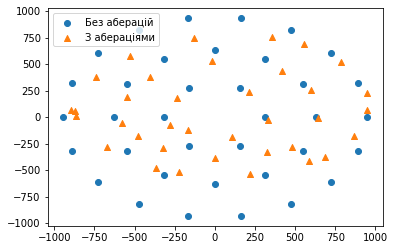

In [ ]:

idx = 1

healthy_pts = np.zeros((total_pts_num, 2))
for j in range(total_pts_num):
    healthy_pts[j,0], healthy_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, np.array([0]))

# for i in range(800):
print("idx: " + str(i))
plt.scatter(healthy_pts[:, 0], healthy_pts[:, 1], label = "Без аберацій")
plt.scatter(out_pts_sorted[idx, :, 0], out_pts_sorted[idx, :, 1], marker = '^', label = "З абераціями")
# plt.xlim([-1000, 1300])
# plt.axis('scaled')
plt.legend()
plt.show()


In [ ]:
plt.scatter(out_pts_sorted[2, :, 0], out_pts_sorted[2, :, 1])
plt.show()

In [ ]:
from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

Simple way of approximate image - as a mean of neares images from the database

In [ ]:
# Generate image which should be close to the unprocessed sample as a weightened sum of nearest sets
valid_idx = 607
neighbor_num = 100

nbrs = NearestNeighbors(algorithm='ball_tree', n_neighbors = neighbor_num).fit(train_vectors)
_, nearest_vect_idxs = nbrs.kneighbors((valid_vectors[valid_idx])[np.newaxis])

nearest_samples = out_pts[nearest_vect_idxs]
app_sample = np.mean(nearest_samples, axis = 1)

# app_sample = np.zeros((total_pts_num, 2))
# for i in range(total_pts_num):
#     app_sample[i] = geometric_median(nearest_samples[0,:,i])

IndexError: ignored

Adjust approximate image using "Coarse-to-fine" principle - minimize sum of squares of distances between all the approximate and all the unassigned points using gradient descent on Zernike coefficients. It's done step-by-step: from low order ("coarse") to high order ("fine") coefficients.

In [ ]:
maxIterPerCoeff = 10
learning_rate = 1.0e-30

# ipdb.set_trace()
A = calc_A(in_pts, pupil_radius, np.size(C_min_max, 0))
C = zern_C_calc(A, app_sample[0], pupil_radius)
ipdb.set_trace()
C = C[1:]

# Unaberrated points in retina
h_pts = np.zeros((total_pts_num, 2))
for j in range(total_pts_num):
    h_pts[j,0], h_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, [0.0])
unknown_pts = out_pts[valid_idxs[valid_idx]]

for c_idx in range(np.size(C, 0)):
    for iter_num in range(maxIterPerCoeff):
        # Calculate gradient for current coefficient
        dist_grad = 0.0
        for i in range(total_pts_num):
            for j in range(total_pts_num):
                Ay_idx = j
                Ax_idx = j + total_pts_num
                ay_c = np.matmul(A[Ay_idx,:], C)
                ax_c = np.matmul(A[Ax_idx,:], C)
                y_part_grad = -2.0 * (unknown_pts[i,0] - h_pts[j,0] - ay_c) * A[Ay_idx, c_idx]
                x_part_grad = -2.0 * (unknown_pts[i,1] - h_pts[j,1] - ax_c) * A[Ax_idx, c_idx]
                dist_grad += y_part_grad + x_part_grad
        # Update coefficient value
        C[c_idx] = C[c_idx] - learning_rate * dist_grad

# ipdb.set_trace()
C = np.concatenate((np.array([0.0]), C), 0)
adj_app_pts = np.zeros((total_pts_num, 2))
for j in range(total_pts_num):
    adj_app_pts[j,0], adj_app_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, C)

# Regression Effectiveness Check
In this approach we'll use linear regression least squares method to compose 
approximation image. Assume that Zernike coefficients are weightened sum of all point's coordinates present in sorted vector: `C = X*R`, where `C` - Zernike coefficient, `X` - vector composed from points' sorted coordinates, `R` - regression coefficients.

In [ ]:
R = np.zeros((total_pts_num*2, np.size(C_min_max, 0)))

R = np.transpose(R) # Needed for dimension alignment
for i in range(np.size(C_min_max, 0)-1):
    # ipdb.set_trace()
    X = train_vectors
    X_T = np.transpose(X)
    Y = np.transpose(C_rnd[train_idxs, i + 1])
    tmp = np.matmul(X_T, X)
    tmp = np.linalg.inv(tmp)
    tmp = np.matmul(tmp, X_T)
    tmp = np.matmul(tmp, Y)
    R[i] = np.transpose(tmp)
R = np.transpose(R) # Needed for dimension alignment

# # Create approximate image
# C_app = np.zeros((np.size(C_min_max, 0), 1))
# for i in range(1, np.size(C_min_max, 0)):
#     # ipdb.set_trace()
#     C_app[i] = np.matmul(valid_vectors[valid_idx], R[:,i-1])

# adj_app_pts = np.zeros((total_pts_num, 2))
# for j in range(total_pts_num):
#     adj_app_pts[j,0], adj_app_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, C_app) 

Polynomial regression preparation

In [ ]:
# prepare polynomial features X (made of our sorted vectors)
poly = PolynomialFeatures(2, include_bias=False)
poly_features = poly.fit_transform(train_vectors)
print(poly.n_output_features_)

regr_list = []
for i in range(np.size(C_avg_std, 0)-3):
    poly_reg_model = sklearn.linear_model.LinearRegression()
    poly_reg_model.fit(poly_features, C_rnd[train_idxs, i + 3])
    regr_list.append(poly_reg_model)

# print(regr_list[0].coef_)

2700


Prepare classification by distance and mathematical expectations

In [ ]:
# Calculate mean value for each retina responce point
mean_retina_pts = np.mean(out_pts, axis=0)

# Calculate standard deviation of distances from mean points
dists = np.zeros((samples_num, total_pts_num))
for i in range(samples_num):
    for j in range(total_pts_num):
        dists[i,j] = numpy.linalg.norm(out_pts[i,j,:]-mean_retina_pts[j,:])
dists_std = np.std(dists, axis=0)

In [ ]:
def gaussian(x, std, mean):
    return (1./(std*np.sqrt(2*np.pi)))*np.exp(-0.5*np.power((x-mean)/std,2))

In [ ]:
plt.scatter(app_sample[0,:, 0], app_sample[0,:, 1], c='green')
plt.scatter(out_pts[valid_idxs[valid_idx], :, 0], out_pts[valid_idxs[valid_idx], :, 1],c='red')
plt.scatter(adj_app_pts[:, 0], adj_app_pts[:, 1], c='blue')
plt.show()

NameError: ignored

Solve assignment problem using Hungarian algorithm

In [ ]:
# Calculate matrix of distances between approximate image and sample
dist_matrix = sc.spatial.distance.cdist(out_pts_sorted[valid_idxs[valid_idx]], adj_app_pts)

munk_solver = Munkres()
indexes_m = munk_solver.compute(dist_matrix)
indexes_nearest = np.argmin(dist_matrix, axis= 1)

# Show info
err_num = 0
for i in range(total_pts_num):
    print("real index: " + np.array2string(orders[valid_idxs[valid_idx], i]) + ", munkres: " + str(indexes_m[i][1]) + ", neares: " + str(indexes_nearest[i]))
    if (indexes_m[i][1] != orders[valid_idxs[valid_idx], i]):
        err_num += 1

print("errors: " + str(err_num))

NameError: ignored

In [ ]:
neighbor_num = 4
nbrs = NearestNeighbors(algorithm='ball_tree', n_neighbors = neighbor_num).fit(train_vectors)

munk_solver = Munkres()

error_arr = np.zeros((np.size(valid_idxs, 0)))

poly_features_valid = poly.fit_transform(valid_vectors)

max_dist_sum = 0
max_sum_idx = 0

for i in range(np.size(valid_idxs,0)):
    # nearest_vect_dist, nearest_vect_idxs = nbrs.kneighbors((valid_vectors[i])[np.newaxis])

    # nearest_samples = out_pts[nearest_vect_idxs]
    # app_sample = np.mean(nearest_samples, axis = 1)

    # nearest_vect_dist[0] /= np.amax(nearest_vect_dist[0])
    # weights = 1 - np.exp(nearest_vect_dist[0]) / np.sum(np.exp(nearest_vect_dist[0]))
    # app_sample = np.zeros((total_pts_num, 2))
    # for j in range(neighbor_num):
    #     app_sample[:,0] = app_sample[:,0] + nearest_samples[0,j,:,0] * np.repeat(weights[j], total_pts_num)
    #     app_sample[:,1] = app_sample[:,1] + nearest_samples[0,j,:,1] * np.repeat(weights[j], total_pts_num)

    # app_sample = np.zeros((total_pts_num, 2))
    # for j in range(total_pts_num):
    #     app_sample[j] = geometric_median(nearest_samples[0,:,j])

    # # Create approximate image (linear regression)
    # C_app = np.zeros((np.size(C_min_max, 0), 1))
    # for j in range(1, np.size(C_min_max, 0)):
    #     # ipdb.set_trace()
    #     C_app[j] = np.matmul(valid_vectors[i], R[:,j-1])

    # Create approximate image (polynomial regression)
    C_app = np.zeros((np.size(C_avg_std, 0), 1))
    for j in range(3, np.size(C_avg_std, 0)):
        C_app[j] = regr_list[j-3].predict(poly_features_valid[i].reshape(1, -1))

    adj_app_pts = np.zeros((total_pts_num, 2))
    for j in range(total_pts_num):
        adj_app_pts[j,0], adj_app_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, C_app) 

    dist_matrix = sc.spatial.distance.cdist(out_pts_sorted[valid_idxs[i]], adj_app_pts)

    health_dist = sc.spatial.distance.cdist(out_pts_sorted[valid_idxs[i]], healthy_pts)
    if (max_dist_sum < np.sum(health_dist)):
        max_dist_sum = np.sum(health_dist)
        max_sum_idx = i

    indexes_m = munk_solver.compute(dist_matrix)
    # indexes_nearest = np.argmin(dist_matrix, axis= 1)

    error_arr[i] = 0

    for j in range(total_pts_num):
        if (orders[valid_idxs[i], j] != indexes_m[j][1]):
            error_arr[i] = error_arr[i] + 1

print("avg err: " + str(np.mean(error_arr) / total_pts_num))
print("max err: " + str(np.amax(error_arr)) + " (" + str(np.argmax(error_arr)) + ")")
print("max sum idx: " + str(max_sum_idx))
print("max sum val: " + str(max_dist_sum))

avg err: 0.0
max err: 0.0 (0)
max sum idx: 0
max sum val: 1339307.4226797756


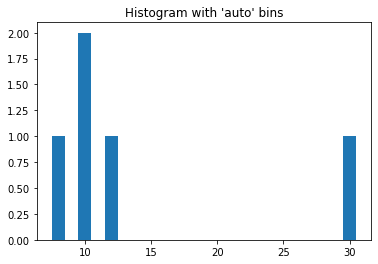

In [ ]:
err_unique = np.unique(error_arr)
# ipdb.set_trace()
err_unique = err_unique[err_unique != 0]
err_arr_show = error_arr[error_arr != 0]
# err_hist_range = np.zeros((np.size(err_unique,0)*2))
# for i in range(np.size(err_unique,0)):
#     err_hist_range[i*2] = err_unique[i]-0.5
#     err_hist_range[i*2+1] = err_unique[i]+0.5


left_of_first_bin = err_unique.min() - 0.5
right_of_last_bin = err_unique.max() + 0.5
# plt.hist(err_arr_show, np.arange(left_of_first_bin, right_of_last_bin+1, 1))
plt.hist(err_arr_show, np.arange(left_of_first_bin, right_of_last_bin+1, 1))
plt.title("Histogram with 'auto' bins")
plt.show()

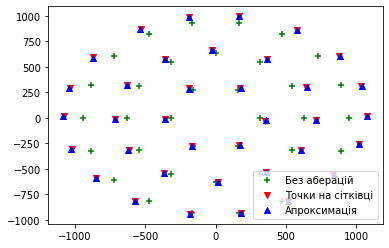

In [ ]:
# Create approximate image (polynomial regression)
idx = 0
C_app = np.zeros((np.size(C_avg_std, 0), 1))
for j in range(3, np.size(C_avg_std, 0)):
    C_app[j] = regr_list[j-3].predict(poly_features_valid[idx].reshape(1, -1))
adj_app_pts = np.zeros((total_pts_num, 2))
for j in range(total_pts_num):
    adj_app_pts[j,0], adj_app_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, C_app) 

healthy_pts = np.zeros((total_pts_num, 2))
for j in range(total_pts_num):
    healthy_pts[j,0], healthy_pts[j,1] = zern_eye_model(in_pts[j,0], in_pts[j,1], pupil_radius, np.array([0, 0]))

plt.scatter(healthy_pts[:, 0], healthy_pts[:, 1], c='green', marker = "+", label = "Без аберацій")
plt.scatter(out_pts[valid_idxs[idx], :, 0], out_pts[valid_idxs[idx], :, 1], marker="v", c='red', label = "Точки на сітківці")
plt.scatter(adj_app_pts[:, 0], adj_app_pts[:, 1], c='blue', marker = "^", label = "Апроксимація")
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(C_rnd[valid_idxs[idx]])

[ 0.          0.          0.          0.         -0.75490528 -0.98189756
 -0.05108749  0.22859851 -0.00703754  0.05712952 -0.06610138 -0.1421854
 -0.06169724 -0.14286485 -0.14912887  0.04265317  0.09949713  0.03999927
 -0.0360882  -0.01717211  0.00905289  0.0815906   0.05447295 -0.00811271
 -0.09068773  0.05069765 -0.02881582  0.02944756]


# Miscellaneous paragraph

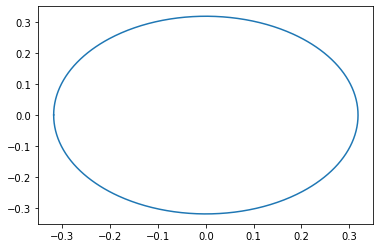

In [ ]:
x = []
y = []
for t in np.arange(-math.pi, math.pi, 0.01):
    x.append(1 * math.cos(t) / math.pi)
    y.append(1 * math.sin(t) / math.pi)

plt.plot(x, y)
plt.show()

In [ ]:
phis = np.arange(0, 2*math.pi, 0.01)
ros = np.arange(0, 1, 0.01)
mode = np.zeros((np.size(ros,0) * np.size(phis,0),))
print(np.shape(mode))

i = 0
for ro in ros:
    for phi in phis:
        mode[i] = pow(12, 0.5)*(10*pow(ro,5) - 12*pow(ro,3) + 3*ro) * math.sin(phi)
        # mode[i] = (10*pow(ro,5) - 12*pow(ro,3) + 3*ro) * math.sin(phi)
        i = i + 1

mode_mean = np.sum(mode) / i
mode_std = np.std(mode)
mode_variance = pow(mode_std, 2)
print(mode_mean)
print(mode_std)
print(mode_variance)

(62900,)
-9.67034858304608e-07
0.9865296010559131
0.9732406537595392
